<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Computação em Nuvem II
Caderno de **Exercícios**<br> 
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>AWS Lambda;</li>
  <li>AWS Step Functions;</li>
  <li>AWS EventBridge.</li>
</ol>

---

# **Exercícios**

## 1\. AWS Lambda

O AWS [Lambda](https://aws.amazon.com/pt/lambda/) é um serviço de computação orientado a evento e sem servidor. Permite a execução de uma função em diversas linguagens de programação que utilize entre 128 MB e 10 GB de memória RAM e que dure, no máximo, 15 minutos. É conhecido com FaaS (*function as a service*) ou função como serviço.

---



> O nome do serviço é inspirado em funções lambda do paradigma funcional.

### **1.1. Funcionamento** 

 1. Ao criar uma função, o *runtime* (linguagem de programação + versão) é escolhida;
 1. A função sempre recebe dois parametros: `event` (*input*) e `context` (execução);
 1. Código refatorado precisa ser implantado (*deploy*);
 1. Código pode ser testado;
 1. Recursos (memória e tempo de execução) podem ser configurados;
 1. Funções precisam de permissão para acessar outros serviços (*buckets*, tabelas, etc.) via AWS [IAM](https://aws.amazon.com/pt/iam/);
 1. Execution logs can be found on AWS [CloudWatch](https://aws.amazon.com/pt/cloudwatch/).

### **1.3. Atividade** 

Extrair dados da site da [B3](https://www.b3.com.br/pt_br/) através de uma [API](https://www2.cetip.com.br/ConsultarTaxaDi/ConsultarTaxaDICetip.aspx):

In [1]:
import json
from datetime import datetime

import requests

# -- setup

URL = 'https://www2.cetip.com.br/ConsultarTaxaDi/ConsultarTaxaDICetip.aspx'

# -- extract

try:
  response = requests.get(URL)
  response.raise_for_status()
except Exception as exc:
  raise exc
else:
  data = json.loads(response.text)
  print(f'1 - {data}')

# -- transform

data['taxa'] = data['taxa'].replace(',', '.')
data['indice'] = data['indice'].replace('.', '').replace(',', '.')

data['dataTaxa'] = datetime.strptime(data['dataTaxa'], '%d/%m/%Y').strftime('%Y-%m-%d')
data['dataIndice'] = datetime.strptime(data['dataIndice'], '%d/%m/%Y').strftime('%Y-%m-%d')
data['dataReferencia'] = datetime.now().strftime('%Y-%m-%d')

data_csv = ','.join([v for v in data.values()])

print(f'2 - {data}')
print(f'3 - {data_csv}')

1 - {'taxa': '13,65', 'dataTaxa': '28/03/2023', 'indice': '39.056,26', 'dataIndice': '29/03/2023'}
2 - {'taxa': '13.65', 'dataTaxa': '2023-03-28', 'indice': '39056.26', 'dataIndice': '2023-03-29', 'dataReferencia': '2023-03-29'}
3 - 13.65,2023-03-28,39056.26,2023-03-29,2023-03-29


Vamos dividir essa etapa em duas: extração e transformação. Logo, temos que:

- Criar um *bucket* no AWS [S3](https://aws.amazon.com/pt/s3/) para salvar o dado original (`bronze`);
- Criar uma função AWS [Lambda](https://aws.amazon.com/pt/lambda/) para extrair o dado original;
- Criar um *bucket* no AWS [S3](https://aws.amazon.com/pt/s3/) para salvar o dado transformado  (`silver`);
- Criar uma função AWS [Lambda](https://aws.amazon.com/pt/lambda/) para transformar o dado original;
- Criar uma função AWS [Lambda](https://aws.amazon.com/pt/lambda/) para criar uma tabela no AWS [Athena](https://aws.amazon.com/pt/athena) apontando para o *bucket* do dado transformado.



Vamos também usar o pacote Python [boto3](https://pypi.org/project/boto3/), o SDK (*software development kit*) da AWS para interação com os serviços da plataforma. A documentação pode ser encontrada neste [link](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html). Exemplo:

```python
import boto3

client = boto3.client('s3')
client.upload_file(Filename='<nome-do-arquivo>', Bucket='<nome-do-bucket>', Key='<nome-do-objeto>')

client = boto3.client('athena')
client.start_query_execution(
  QueryString='SELECT * FROM <nome-da-tabela> LIMIT 10', 
  ResultConfiguration={'OutputLocation': 's3://<nome-do-bucket-de-resultados>/'}
)
```

- Criar um *bucket* no AWS [S3](https://aws.amazon.com/pt/s3/) para salvar o dado original (`bronze`);

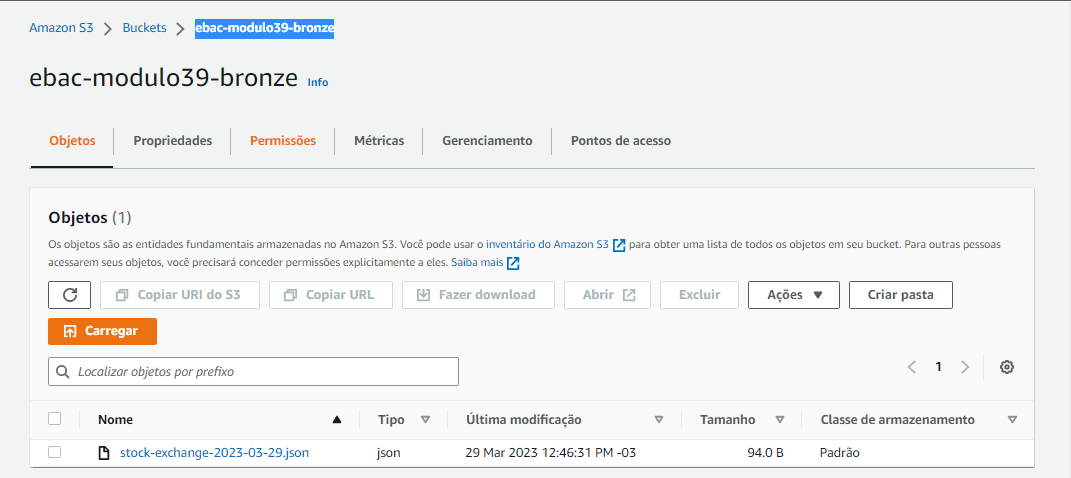

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para *bucket* **bronze**:

In [ ]:
import json
import logging
from datetime import datetime

import boto3
import urllib3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  URL = 'https://www2.cetip.com.br/ConsultarTaxaDi/ConsultarTaxaDICetip.aspx'
  BRONZE_BUCKET = 'ebac-modulo39-bronze'

  client = boto3.client('s3')

  date = datetime.now().strftime('%Y-%m-%d')
  filename_json = f'stock-exchange-{date}.json'

  # -- extract

  try:
    http = urllib3.PoolManager()
    response = http.request(url=URL, method='get')
  except Exception as exc:
    raise exc
  else:
    data = json.loads(response.data.decode())
    logging.info(msg=data)

  # -- transform

  ...

  # -- load

  try:
      with open(f'/tmp/{filename_json}', mode='w', encoding='utf8') as fp:
          json.dump(data, fp)
      client.upload_file(Filename=f'/tmp/{filename_json}', Bucket=BRONZE_BUCKET, Key=filename_json)
  except ClientError as exc:
      raise exc

  return json.dumps(dict(status=True))

- Criar um *bucket* no AWS [S3](https://aws.amazon.com/pt/s3/) para salvar o dado transformado  (`silver`);

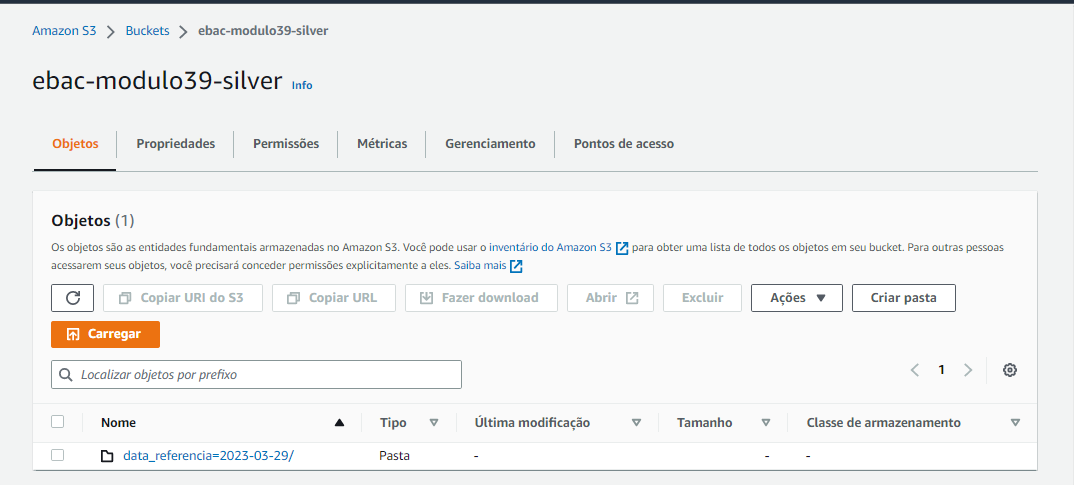

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para *bucket* **silver**:

In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  BRONZE_BUCKET = 'ebac-modulo39-bronze'
  SILVER_BUCKET = 'ebac-modulo39-silver'

  client = boto3.client('s3')

  date = datetime.now().strftime('%Y-%m-%d')
  filename_csv = f'stock-exchange-{date}.csv'
  filename_json = f'stock-exchange-{date}.json'

  # -- extract

  client.download_file(BRONZE_BUCKET, filename_json, f'/tmp/{filename_json}')

  with open(f"/tmp/{filename_json}", mode='r', encoding='utf8') as fp:
      data = json.load(fp)

  # -- transform

  data['taxa'] = data['taxa'].replace(',', '.')
  data['indice'] = data['indice'].replace('.', '').replace(',', '.')

  data['dataTaxa'] = datetime.strptime(data['dataTaxa'], '%d/%m/%Y').strftime('%Y-%m-%d')
  data['dataIndice'] = datetime.strptime(data['dataIndice'], '%d/%m/%Y').strftime('%Y-%m-%d')
 
  # -- load

  try:
      with open(f'/tmp/{filename_csv}', mode='w', encoding='utf8') as fp:
          fp.write(','.join([v for v in data.values()]))
      client.upload_file(Filename=f'/tmp/{filename_csv}', Bucket=SILVER_BUCKET, Key=f'data_referencia={date}/{filename_csv}')
  except ClientError as exc:
      raise exc

  return json.dumps(dict(status=True))

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para tabela:

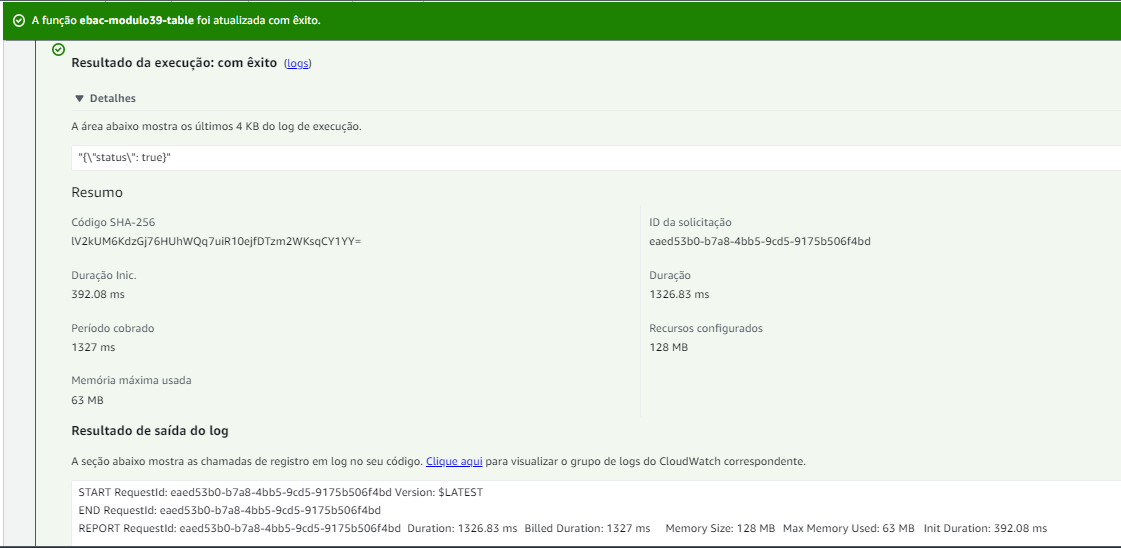

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para tabela:

In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  SILVER_BUCKET = 'ebac-modulo39-silver'

  query = f"""
  CREATE EXTERNAL TABLE IF NOT EXISTS cdi (
    taxa double, 
    data_taxa string, 
    indice double, 
    data_indice string
  )
  PARTITIONED BY (
    data_referencia string
  )
  ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
  WITH SERDEPROPERTIES ('separatorChar'=',') 
  LOCATION 's3://{SILVER_BUCKET}/'
  """

  client = boto3.client('athena')

  # -- create

  try:
    client.start_query_execution(
      QueryString=query, 
      ResultConfiguration={'OutputLocation': 's3://ebac-modulo-38-athena-results/'}
    )
  except ClientError as exc:
    raise exc

  # -- update

  try:
    client.start_query_execution(
      QueryString='MSCK REPAIR TABLE cdi', 
      ResultConfiguration={'OutputLocation': 's3://ebac-modulo-38-athena-results/'}
    )
  except ClientError as exc:
    raise exc

  return json.dumps(dict(status=True))

## 2\. AWS Step Functions

> O AWS [Step Functions](https://aws.amazon.com/pt/step-functions/) é um serviço de orquestração de serviços sem servidor. No contexto de dados, pode atuar como orquestrador de *pipeline* de dados. O serviço é inspirado no famoso projeto *open source* [Apache Airflow](https://airflow.apache.org).



### **2.1. Funcionamento** 

1. Uma *task* ou tarefa é uma unidade de processamento; 
2. Uma *state machine* é a definição de um fluxo de tarefas;
3. Tasks e state machine são definidas com a linguagem JSON.

### **2.2. Atividade** 


 - Criar uma `state machine` com três *tasks*, uma com cada função lambda criada na item 1.3.

> **Criando uma state machine no workflow Step Functions da AWS**

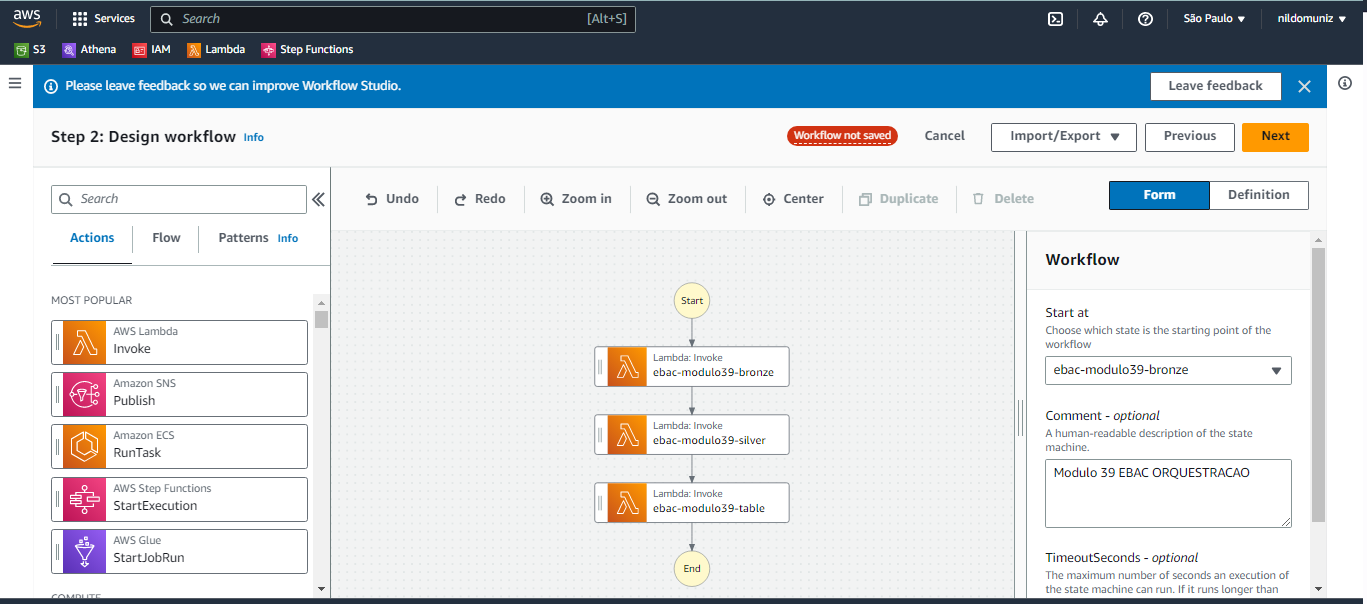

> **Visualizando o código gerado**

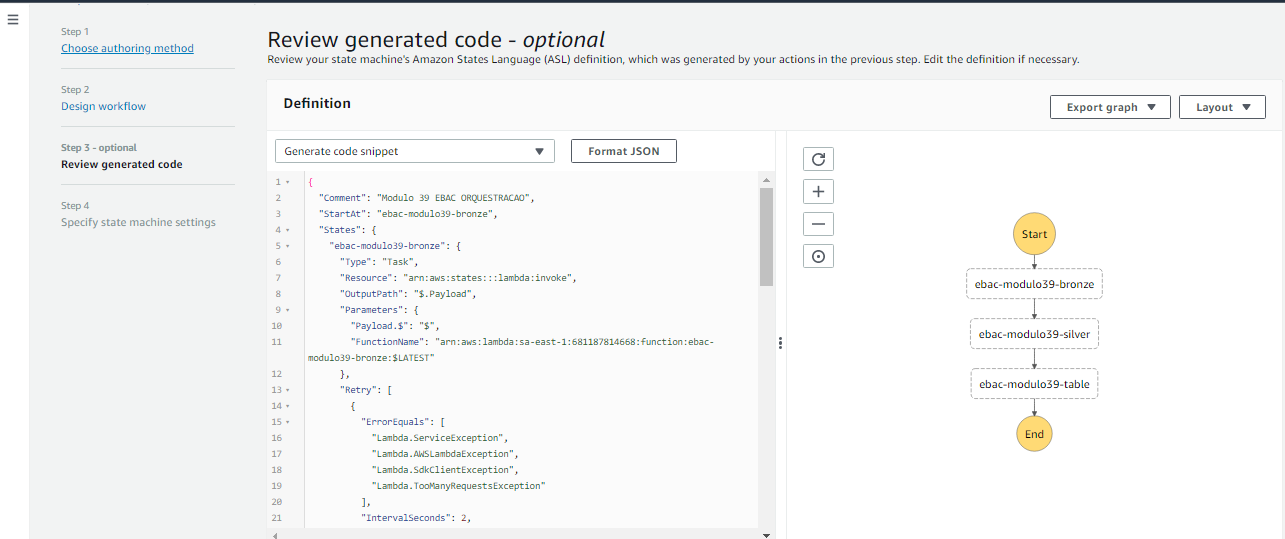

> **Visualização da criação da State Machine realizada com sucesso:**

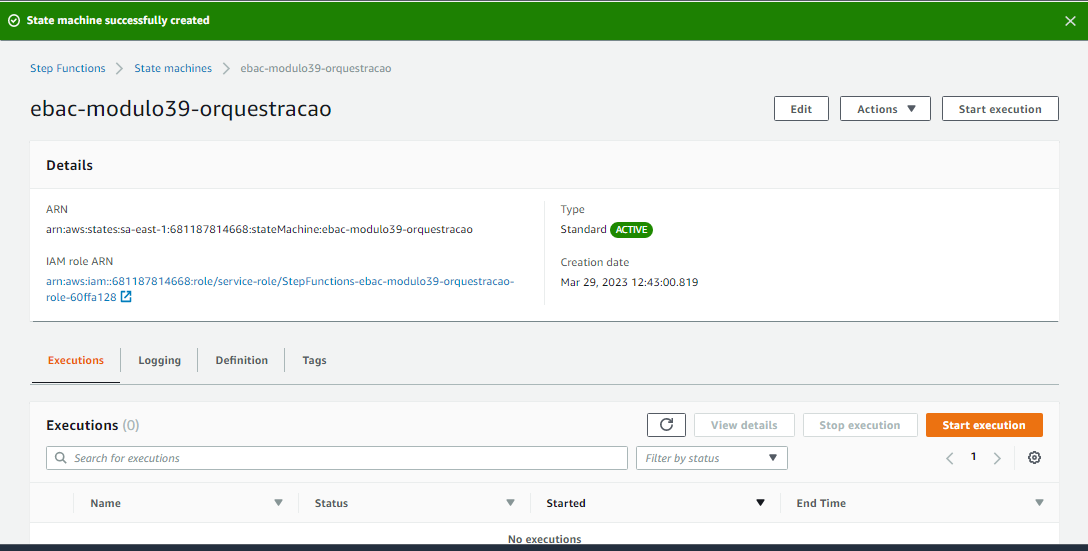

> **Visualizando detalhes/curiosidades da State Machine criada:***

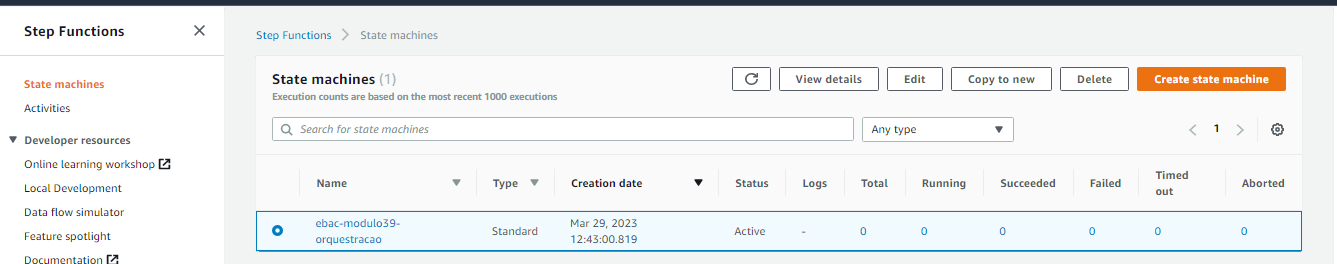

> **Visualização do carregamento realizado com sucesso:**

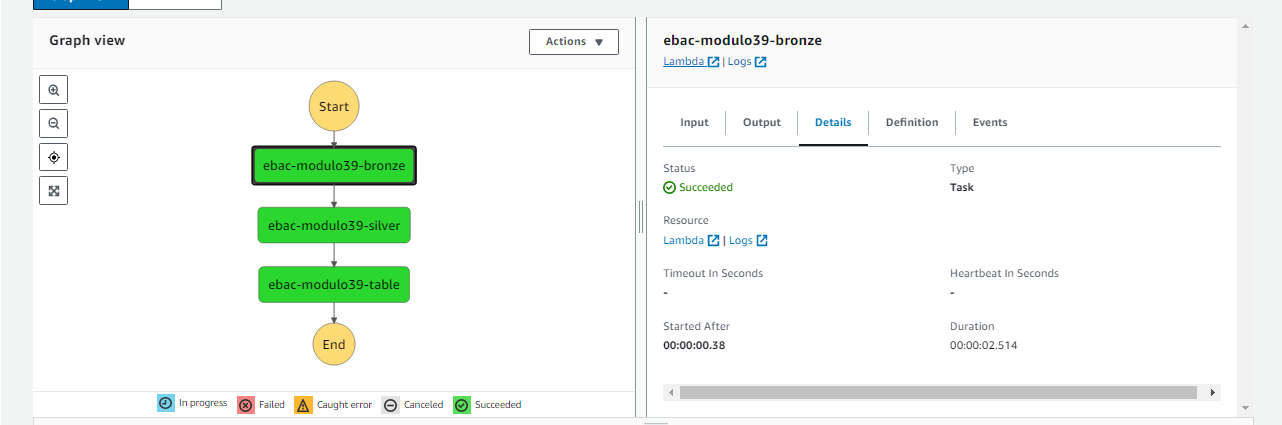

## 3\. AWS EventBridge

> O AWS [EventBridge](https://aws.amazon.com/pt/eventbridge/) é um serviço de barramento de eventos sem servidor. Ele permite que multiplos serviços da AWS se comuniquem de maneira assíncrona através da publicação/consumo de eventos.


### **3.1. Funcionamento** 

1. Uma *rule* ou regra "escuta" eventos e os roteia para serviços da AWS;
2. Eventos podem ser temporais ou publicações de outros serviços da AWS;
2. Eventos também podem se publicados serviços externos (Shopfy, Zendesk, etc.).

### **3.2. Atividade** 

 - Criar um evento que inicie a *state machine* do item 2.3.

> **Definindo o nome e tipo de regra:**

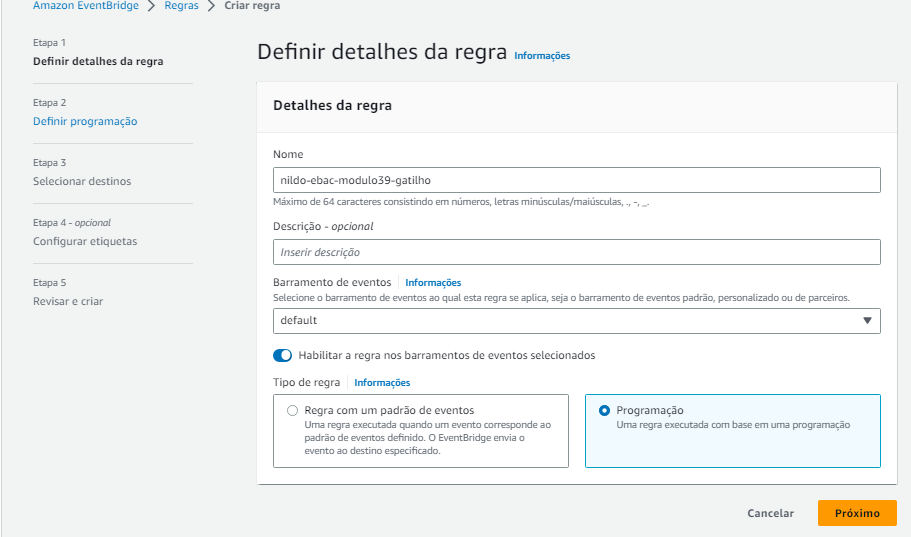

> **Definindo o intervalo da regra (1 dia)**

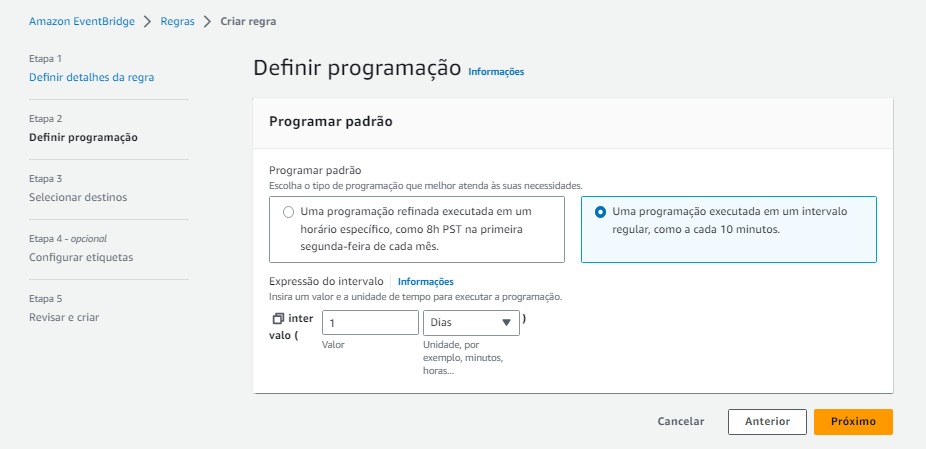

> **Definindo o destino (quem está ouvindo nosso evento):**

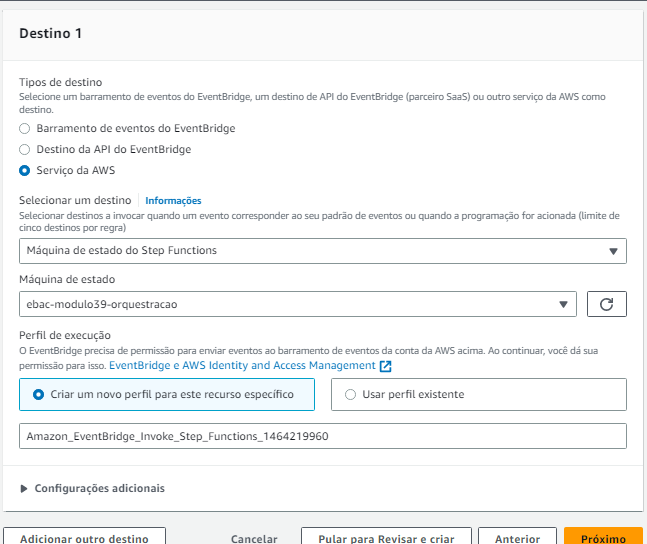

> **Print da regra criada:**

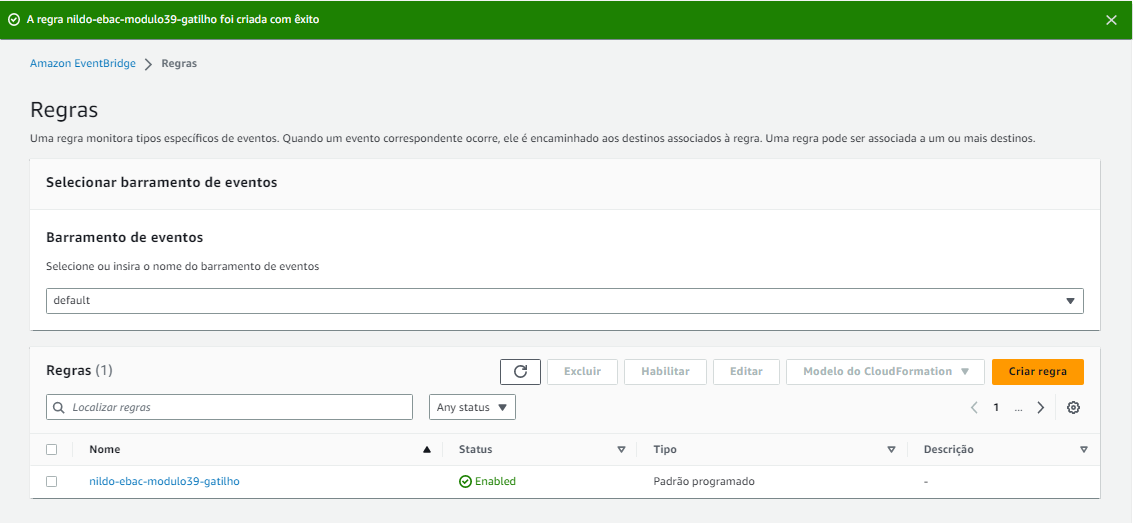